<a href="https://www.kaggle.com/code/vaibsdev/notebook5d95578c5e?scriptVersionId=230777268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import pickle
import warnings
import pandas as pd
!pip install torchinfo
from torchinfo import summary

warnings.filterwarnings('ignore')

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")


def move_to_device(obj, device):
    if isinstance(obj, torch.nn.Module):
        return obj.to(device)
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    return obj


sample_tensor = torch.tensor([1.0]).to(device)
print(f"Tensor on {sample_tensor.device}")


Using device: cuda
CUDA Available: True
CUDA Device Count: 1
CUDA Device Name: Tesla P100-PCIE-16GB
Tensor on cuda:0


In [3]:

class EarlyStopping:
    """Early stopping handler to prevent overfitting"""
    def __init__(self, patience=5, min_delta=0.001, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Save the best model
            torch.save(model.state_dict(), self.save_path)
            print(f"[INFO] Model checkpoint saved to {self.save_path}")
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("[INFO] Early stopping triggered.")
                return True
        return False

In [4]:

csv_path = '/kaggle/input/mst-e-data-1/mst-e_data/mst-e_image_details.csv'
image_data = pd.read_csv(csv_path)


image_paths = []
labels = []


base_image_dir = "/kaggle/input/mst-e-data-1/mst-e_data"


unique_mst_classes = sorted(image_data['MST'].unique())
class_to_idx = {class_name: idx for idx, class_name in enumerate(unique_mst_classes)}
num_classes = len(unique_mst_classes)
print(f"Number of unique MST classes: {num_classes}")
print(f"Class mapping: {class_to_idx}")


for index, row in image_data.iterrows():
    # Get image details from your columns
    image_id = row['image_ID']
    subject_name = row['subject_name']

 
    mst_class = row['MST']
    class_idx = class_to_idx[mst_class]

    image_path = os.path.join(base_image_dir, subject_name, f"{image_id}")

    # Skip if this is an MP4 file
    if image_path.lower().endswith('.mp4'):
        continue

    
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(class_idx)  
    else:
        print(f"Image not found: {image_path}")

print(f"Found {len(image_paths)} images across {num_classes} MST classes")

Number of unique MST classes: 10
Class mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}
Image not found: /kaggle/input/mst-e-data-1/mst-e_data/subject_18/PXL_20220922_183142438.jpg 
Image not found: /kaggle/input/mst-e-data-1/mst-e_data/subject_2/bottom
Found 1510 images across 10 MST classes


In [5]:
class SkinToneDataset(Dataset):
    """Custom Dataset for loading skin tone images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

In [6]:
class SkinToneModel(nn.Module):
    """Convolutional Neural Network for skin tone classification"""
    def __init__(self, num_classes, dropout_rate=0.5):
        super(SkinToneModel, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #  Block 5
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)
        x = self.fc_block(x)
        return x


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = SkinToneDataset(image_paths, labels, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,persistent_workers=True,pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,persistent_workers=True,pin_memory = True)

device = torch.device("cuda" if torch.cuda.is_available() else print("ERROR"))
model = SkinToneModel(num_classes=num_classes).to(device)


print("Basic Model:")
print(summary(model, input_size=(1, 3, 224, 224)))
# print("\nLighting-Aware Model:")
# print(summary(lighting_model, input_size=(1, 3, 224, 224)))


criterion = nn.CrossEntropyLoss()
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Basic Model:
Layer (type:depth-idx)                   Output Shape              Param #
SkinToneModel                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 112, 112]        256
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-8                    [1, 128, 56, 56]          --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]      

In [7]:
#FOR NORMAL MODEL
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move to GPU

        optimizer.zero_grad()  

        outputs = model(inputs)  
        loss = criterion(outputs, labels)

        loss.backward()  
        optimizer.step() 

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total
    print(epoch_loss)
    print(epoch_acc)

    return epoch_loss, epoch_acc


# Ensure model is on GPU
model.to(device)


early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path="best_skin_tone_model.pth")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

     # Save loss and accuracy for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if early_stopping(val_loss, model):
        print(f"Training stopped early at epoch {epoch+1}")
        break

print(f'Training complete! Best validation loss: {early_stopping.best_loss:.4f}')

# Load the best model for evaluation
model.load_state_dict(torch.load(early_stopping.save_path, map_location=device))
final_val_loss, final_val_acc = validate(model, val_loader, criterion, device)
print(f'Final model performance - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_acc:.2f}%')

1.7302867300463038
36.75496688741722
Epoch 1/30: Train Loss: 1.7244, Train Acc: 37.91%, Val Loss: 1.7303, Val Acc: 36.75%
[INFO] Model checkpoint saved to best_skin_tone_model.pth
1.4249012750505612
51.65562913907285
Epoch 2/30: Train Loss: 1.1945, Train Acc: 56.54%, Val Loss: 1.4249, Val Acc: 51.66%
[INFO] Model checkpoint saved to best_skin_tone_model.pth
0.7447077478004607
72.18543046357615
Epoch 3/30: Train Loss: 0.8409, Train Acc: 70.28%, Val Loss: 0.7447, Val Acc: 72.19%
[INFO] Model checkpoint saved to best_skin_tone_model.pth
0.45886325421712254
83.44370860927152
Epoch 4/30: Train Loss: 0.6803, Train Acc: 76.24%, Val Loss: 0.4589, Val Acc: 83.44%
[INFO] Model checkpoint saved to best_skin_tone_model.pth
1.0585532598937584
65.23178807947019
Epoch 5/30: Train Loss: 0.5663, Train Acc: 79.14%, Val Loss: 1.0586, Val Acc: 65.23%
0.46514841874703666
84.43708609271523
Epoch 6/30: Train Loss: 0.4149, Train Acc: 85.68%, Val Loss: 0.4651, Val Acc: 84.44%
0.30565316649462215
87.74834437086

In [8]:

class SkinToneDataset(Dataset):
    """Custom Dataset for loading skin tone images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)
class LightingAwareAttention(nn.Module):
    """Attention mechanism to focus on lighting-invariant features"""
    def __init__(self, in_channels):
        super(LightingAwareAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Global average pooling to capture lighting information
        avg_pool = torch.mean(x, dim=[2, 3], keepdim=True)
        
        # Apply attention calculation
        y = self.conv1(avg_pool)
        y = nn.ReLU()(y)
        y = self.conv2(y)
        y = self.sigmoid(y)
        
        # Apply attention weights to input features
        return x * y

class SkinToneModelWithLighting(nn.Module):
    """Convolutional Neural Network for skin tone classification with lighting awareness"""
    def __init__(self, num_classes, dropout_rate=0.5):
        super(SkinToneModelWithLighting, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Add first lighting attention after initial feature extraction
        self.lighting_attention1 = LightingAwareAttention(128)
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Add second lighting attention for higher-level features
        self.lighting_attention2 = LightingAwareAttention(512)
        
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding="same"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dual branch for skin tone and lighting-aware features
        self.skin_tone_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )
        
        self.lighting_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
        )
        
        # Combine both branches for final classification
        self.classifier = nn.Linear(256 + 128, num_classes)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        
        # Apply first lighting attention
        x = self.lighting_attention1(x)
        
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        
        # Apply second lighting attention
        x = self.lighting_attention2(x)
        
        x = self.conv_block5(x)
        x = self.global_avg_pool(x)
        
        # Split into two branches
        skin_features = self.skin_tone_branch(x)
        lighting_features = self.lighting_branch(x)
        
        # Concatenate features from both branches
        combined_features = torch.cat((skin_features, lighting_features), dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        
        return output

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = SkinToneDataset(image_paths, labels, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,persistent_workers=True,pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4,persistent_workers=True,pin_memory = True)

lighting_model = SkinToneModelWithLighting(num_classes=num_classes).to(device)
print("\nLighting-Aware Model:")
print(summary(lighting_model, input_size=(1, 3, 224, 224)))
criterion = nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(lighting_model.parameters(), lr=0.001)






Lighting-Aware Model:
Layer (type:depth-idx)                   Output Shape              Param #
SkinToneModelWithLighting                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 112, 112]        256
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-8                    [1, 128, 56, 56]          --
├─LightingAwareAttention: 1-3            [1, 128, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 16, 1, 1

In [9]:
#FOR LIGHT ATTENTION
def train_one_epoch(lighting_model, dataloader, criterion, optimizer, device):
    lighting_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move to GPU

        optimizer.zero_grad()  

        outputs = lighting_model(inputs)  
        loss = criterion(outputs, labels)

        loss.backward()  
        optimizer.step() 

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc

def validate(lighting_model, dataloader, criterion, device):
    lighting_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = lighting_model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100.0 * correct / total
    print(epoch_loss)
    print(epoch_acc)

    return epoch_loss, epoch_acc


# Ensure model is on GPU
lighting_model.to(device)


early_stopping = EarlyStopping(patience=5, min_delta=0.001, save_path="best_skin_tone_model_with_lightingAttention.pth")

train1_losses = []
val1_losses = []
train1_accuracies = []
val1_accuracies = []
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(lighting_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(lighting_model, val_loader, criterion, device)

     # Save loss and accuracy for visualization
    train1_losses.append(train_loss)
    val1_losses.append(val_loss)
    train1_accuracies.append(train_acc)
    val1_accuracies.append(val_acc)


    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if early_stopping(val_loss, lighting_model):
        print(f"Training stopped early at epoch {epoch+1}")
        break

print(f'Training complete! Best validation loss: {early_stopping.best_loss:.4f}')

# Load the best model for evaluation
lighting_model.load_state_dict(torch.load(early_stopping.save_path, map_location=device))
final_val_loss, final_val_acc = validate(lighting_model, val_loader, criterion, device)
print(f'Final model performance - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_acc:.2f}%')

1.5988480539511372
44.70198675496689
Epoch 1/30: Train Loss: 1.7470, Train Acc: 37.17%, Val Loss: 1.5988, Val Acc: 44.70%
[INFO] Model checkpoint saved to best_skin_tone_model_with_lightingAttention.pth
0.9890546988177773
62.25165562913907
Epoch 2/30: Train Loss: 1.0802, Train Acc: 60.60%, Val Loss: 0.9891, Val Acc: 62.25%
[INFO] Model checkpoint saved to best_skin_tone_model_with_lightingAttention.pth
1.3046862226448313
58.27814569536424
Epoch 3/30: Train Loss: 0.8084, Train Acc: 69.78%, Val Loss: 1.3047, Val Acc: 58.28%
0.45889954752479956
81.12582781456953
Epoch 4/30: Train Loss: 0.5055, Train Acc: 81.79%, Val Loss: 0.4589, Val Acc: 81.13%
[INFO] Model checkpoint saved to best_skin_tone_model_with_lightingAttention.pth
0.7763032257951648
73.17880794701986
Epoch 5/30: Train Loss: 0.4788, Train Acc: 83.11%, Val Loss: 0.7763, Val Acc: 73.18%
0.8296758173317309
68.21192052980132
Epoch 6/30: Train Loss: 0.3762, Train Acc: 87.42%, Val Loss: 0.8297, Val Acc: 68.21%
0.3448846132944751
85.76

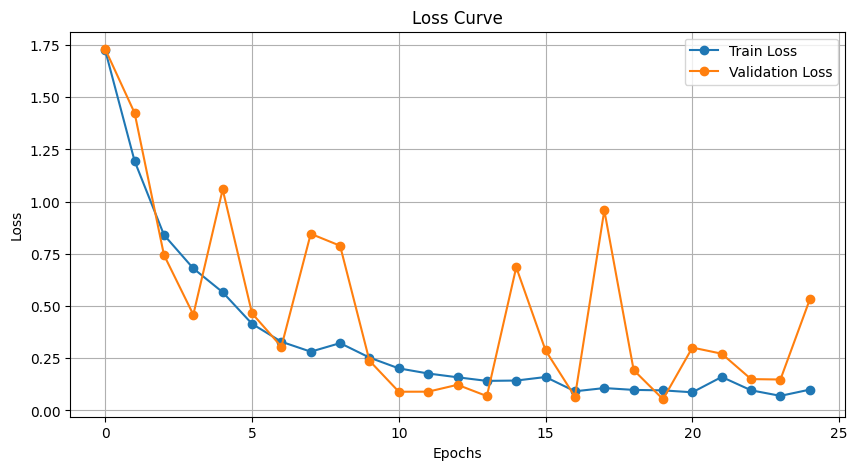

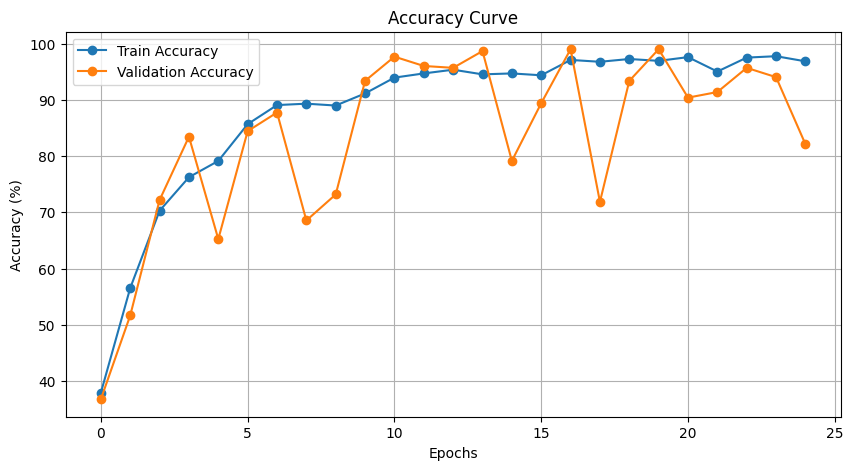

In [10]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy", marker="o")
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

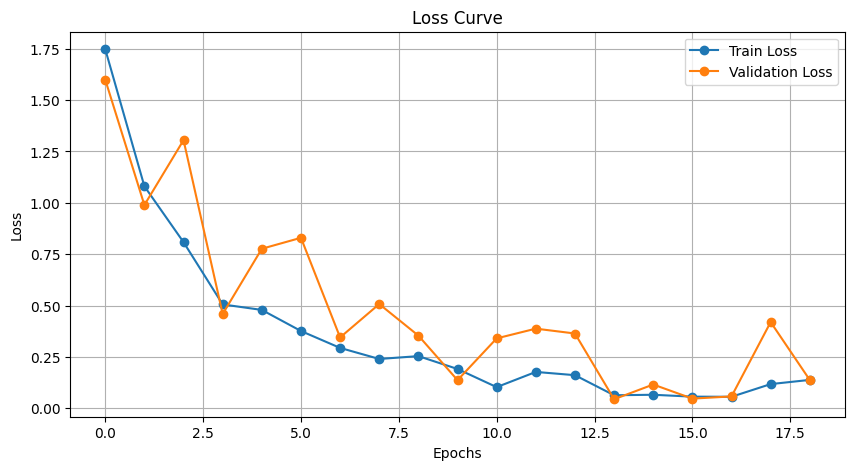

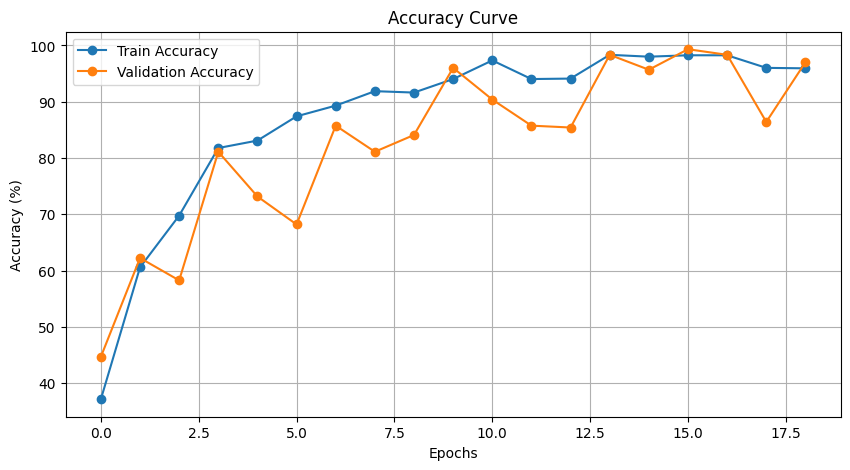

In [11]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train1_losses, label="Train Loss", marker="o")
plt.plot(val1_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(train1_accuracies, label="Train Accuracy", marker="o")
plt.plot(val1_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

,Epoch,Train Loss (Normal),Val Loss (Normal),Train Acc (Normal),Val Acc (Normal),Train Loss (Light Attention),Val Loss (Light Attention),Train Acc (Light Attention),Val Acc (Light Attention)
0,1,1.724422,1.730287,37.913907,36.754967,1.747033,1.598848,37.168874,44.701987
1,2,1.194535,1.424901,56.539735,51.655629,1.080196,0.989055,60.596026,62.251656
2,3,0.840874,0.744708,70.281457,72.185430,0.808395,1.304686,69.784768,58.278146
3,4,0.680283,0.458863,76.241722,83.443709,0.505483,0.458900,81.788079,81.125828
4,5,0.566334,1.058553,79.139073,65.231788,0.478754,0.776303,83.112583,73.178808
5,6,0.414909,0.465148,85.678808,84.437086,0.376186,0.829676,87.417219,68.211921
6,7,0.329226,0.305653,89.072848,87.748344,0.293949,0.344885,89.321192,85.761589
7,8,0.281531,0.846209,89.321192,68.543046,0.240149,0.507425,91.887417,81.125828
8,9,0.322537,0.788967,88.990066,73.178808,0.254000,0.353744,91.639073,84.105960
9,10,0.253314,0.238345,91.142384,93.377483,0.191410,0.137133,94.039735,96.026490


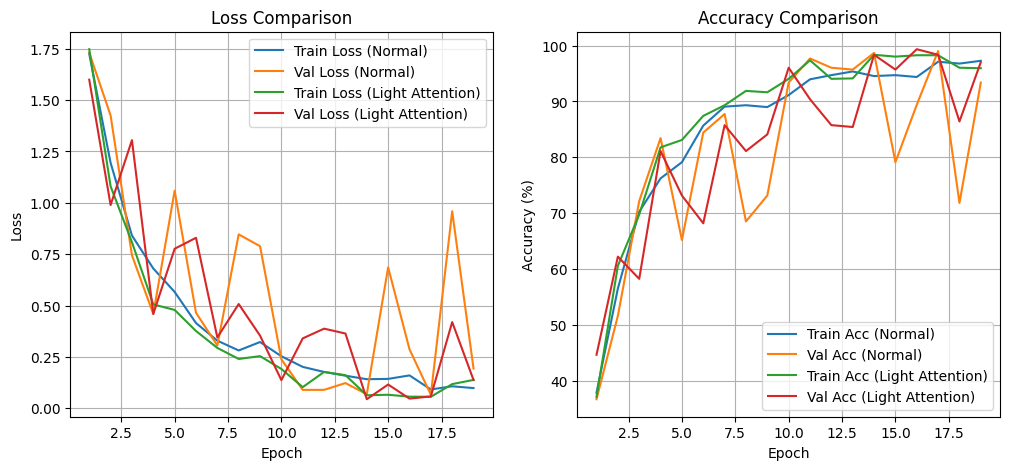

In [12]:
# Ensure all lists are the same length
min_epochs = min(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies),
                 len(train1_losses), len(val1_losses), len(train1_accuracies), len(val1_accuracies))

# Trim lists to the shortest epoch count
train_losses = train_losses[:min_epochs]
val_losses = val_losses[:min_epochs]
train_accuracies = train_accuracies[:min_epochs]
val_accuracies = val_accuracies[:min_epochs]
train1_losses = train1_losses[:min_epochs]
val1_losses = val1_losses[:min_epochs]
train1_accuracies = train1_accuracies[:min_epochs]
val1_accuracies = val1_accuracies[:min_epochs]

# Creating a dataframe for comparison
data = {
    "Epoch": list(range(1, min_epochs + 1)),
    "Train Loss (Normal)": train_losses,
    "Val Loss (Normal)": val_losses,
    "Train Acc (Normal)": train_accuracies,
    "Val Acc (Normal)": val_accuracies,
    "Train Loss (Light Attention)": train1_losses,
    "Val Loss (Light Attention)": val1_losses,
    "Train Acc (Light Attention)": train1_accuracies,
    "Val Acc (Light Attention)": val1_accuracies,
}

results_df = pd.DataFrame(data)
display(results_df)  # Display the table in Jupyter Notebook

# Plot loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results_df["Epoch"], results_df["Train Loss (Normal)"], label='Train Loss (Normal)')
plt.plot(results_df["Epoch"], results_df["Val Loss (Normal)"], label='Val Loss (Normal)')
plt.plot(results_df["Epoch"], results_df["Train Loss (Light Attention)"], label='Train Loss (Light Attention)')
plt.plot(results_df["Epoch"], results_df["Val Loss (Light Attention)"], label='Val Loss (Light Attention)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.grid()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(results_df["Epoch"], results_df["Train Acc (Normal)"], label='Train Acc (Normal)')
plt.plot(results_df["Epoch"], results_df["Val Acc (Normal)"], label='Val Acc (Normal)')
plt.plot(results_df["Epoch"], results_df["Train Acc (Light Attention)"], label='Train Acc (Light Attention)')
plt.plot(results_df["Epoch"], results_df["Val Acc (Light Attention)"], label='Val Acc (Light Attention)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison")
plt.legend()
plt.grid()

plt.show()